In [2]:
import numpy as np
import scipy.linalg as la
import pandas as pd
import random
import matplotlib.pyplot as plt
import itertools

In this notebook we will explore the problem of locating an unknown point based on the known distances from known points. The problem will involve a lot of triangle geometry. Using the known distances, it is possible to derive certain properties of the point. In which case, we want to find the intersection of spheres. We know, for example, that the intersection of two spheres in 3-dimensional space with different centers is either a circle or empty, and the intersection of a circle with a sphere is either at most two different points or empty. This notion can be generalized into multidimensional space.

To find out where the circle is, we need to use triangle geometry. This leads us to the first question: If we have two points a known distance apart, and the third point is a known distance away from each of the two points, where is the third point? In 2D space there are two such points. Since isometric transformations do not change the nature of the problem (except for scaling), it suffices to assume the two points lie on the x-axis, which are $(0,0)$ and $(d,0)$.

By solving this question, we will also know the projection and rejection of the third point onto the vector connecting the other two points. The projection is basically the distance of the third point from the first parallel to the line connecting to the first two points. The rejection is the perpendicular distance from the line. However, there are problems that will occur if we don't choose our parameters properly. This will only work when the three distances are compatible with the triangle inequality. Otherwise, one way to solve the problem is to scale the two measured sides proportionally so that they "just" satisfy the triangle inequality. The rationale for this will be explained later.

The tools we will use to find the projection and rejection of the third point include Heron's formula and the cosine rule.

In [3]:
def find_adjacent_point_position(d1, d2, d3):
    # d1 is the length of the base, d2 is the length of the left side and d3 is the length of the remaining right side
    if (d1 <= d2 + d3) and (d2 <= d1 + d3) and (d3 <= d1 + d2):
        sp = (d1 + d2 + d3) / 2
        area = np.sqrt(sp * (sp-d1) * (sp-d2) * (sp-d3)) # Find the area using Heron's formula

        rej = area / d1 * 2 # Simply by the 1/2 base * height formula

        proj = (d1**2 + d2**2 - d3**2) / (2*d1) # Using the cosine rule, then applying the cosine to the second edge d2
        
    else:
        if d1 > d2 + d3:
            rej = 0
            proj = d2 / (d2+d3) * d1
        else:
            rej = 0
            proj = d2 / (d2-d3) * d1

    return np.array([proj, rej])

In [4]:
for i in range(100):
    # Complete 100 random tests to make sure the algorithm works well, assuming triangle inequality holds
    triangle_inequality = False
    while triangle_inequality == False:
        vertices = np.random.rand(3) * 10
        if (vertices[0] <= vertices[1] + vertices[2]) and (vertices[1] <= vertices[0] + vertices[2]) and (vertices[2] <= vertices[0] + vertices[1]):
            triangle_inequality = True

    proj, rej = find_adjacent_point_position(*vertices)

    try:
        assert(abs(vertices[1] - np.sqrt(proj**2 + rej**2)) <= 10**-12)
        assert(abs(vertices[2] - np.sqrt((vertices[0] - proj)**2 + rej**2)) <= 10**-12)
    except:
        print('Test {} failed.'.format(i+1))

If you see no messages above, this means the test is working as intended. The point being found based on the projection and rejection satisfies the point and distance requirements. However, we are only testing this for the case of triangle inequality being satisfied.

Next, we want to generalize this to having the two known points be at any set of coordinates. Since the projection and rejection can be calculated, in 2 dimensions this means we get two points. In 3 dimensions, we get a circle centered on the line and perpendicular to the line as the set of possible points based on the information.

Later, we will investigate a different algorithm which uses the intersection of planes derived from the properties of the possible point. The method can be generalized to any number of dimensions.

In [5]:
def triangulate(p1, d1, p2, d2):
    dist = np.sqrt(sum((p2-p1)**2))
    proj, rej = find_adjacent_point_position(dist, d1, d2)
    perp = lambda x: np.array([x[1], -x[0]])
    q1 = p1 + proj * (p2-p1) / dist + rej * perp(p2-p1) / dist
    q2 = p1 + proj * (p2-p1) / dist - rej * perp(p2-p1) / dist

    return q1,q2

for i in range(100):
    triangle_inequality = False
    while triangle_inequality == False:
        p1 = np.random.rand(2) * 10
        p2 = np.random.rand(2) * 10
        d1 = np.random.rand() * 10
        d2 = np.random.rand() * 10

        dist = np.sqrt(sum((p1-p2)**2))
        if (dist <= d1 + d2) and (d1 <= dist + d2) and (d2 <= dist + d1):
            triangle_inequality = True

    q1, q2 = triangulate(p1,d1,p2,d2)

    try:
        assert(abs(np.sqrt(sum((q1 - p1)**2)) - d1) <= 10**-12)
        assert(abs(np.sqrt(sum((q2 - p1)**2)) - d1) <= 10**-12)
        assert(abs(np.sqrt(sum((q1 - p2)**2)) - d2) <= 10**-12)
        assert(abs(np.sqrt(sum((q2 - p2)**2)) - d2) <= 10**-12)
    except:
        print('Test {} failed.'.format(i+1))

In [6]:
def measure_satellite_distances(satellite_positions, point, error=0.01):
    no_of_satellites = np.shape(satellite_positions)[0]

    # Measure the distance of each satellite to the point
    satellite_distances = np.sqrt((point[0] - satellite_positions[:,0])**2 + (point[1] - satellite_positions[:,1])**2)

    # Add some noise to the distance measurements, with a normal standard error of (default: 1%, 0.01)
    satellite_distances += np.random.standard_normal(no_of_satellites) * satellite_distances * error

    return satellite_distances

Now we apply this algorithm to the problem of measuring points in 2D space. After measuring distances from two of the satellites to the unknown point with a small normal (Gaussian) error, we will use each set of two satellites to find a point based on the measurements. A third satellite will also be used to disambiguate which of the two points is the correct point by choosing the point whose distance is closer to the measurement. This will, however, create problems if the three satellites are collinear.

In [7]:
def measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func=None, plot_results=False):
    '''This function takes in a set of satellite positions and the distances they measure to the point, then estimates a point based on the triangulation algorithm with a weighting function, default evenly weighted. Results may be plotted if desired'''
    no_of_satellites = np.shape(satellite_positions)[0]

    measured_points = np.empty((0,7))
    rejected_points = np.empty((0,2))

    # To measure the point, pick each possible pair of two satellites, and use this and the triangulation algorithm to find two possible points for the pair. There will be nC2 measurements taken, where n is the number of satellites that are measuring. (Note: This only works in 2 dimensions)
    for i in range(no_of_satellites):
        for j in range(i+1,no_of_satellites):
            satellite_pos_1 = satellite_positions[i]
            satellite_dis_1 = satellite_distances[i]
            satellite_pos_2 = satellite_positions[j]
            satellite_dis_2 = satellite_distances[j]

            # Choose a random third satellite to find which of two points matches the measured distance to this third satellite more closely
            k = i
            while k in [i,j]:
                k = np.random.randint(no_of_satellites)
            satellite_pos_3 = satellite_positions[k]
            satellite_dis_3 = satellite_distances[k]
            
            measured_point_1 = triangulate(satellite_pos_1, satellite_dis_1, satellite_pos_2, satellite_dis_2)[0]
            measured_point_2 = triangulate(satellite_pos_1, satellite_dis_1, satellite_pos_2, satellite_dis_2)[1]

            measured_dist_1 = np.sqrt(sum((measured_point_1 - satellite_pos_3)**2))
            measured_dist_2 = np.sqrt(sum((measured_point_2 - satellite_pos_3)**2))

            if abs(measured_dist_1 - satellite_dis_3) < abs(measured_dist_2 - satellite_dis_3):
                measured_point = measured_point_1
                rejected_point = measured_point_2
            else:
                measured_point = measured_point_2
                rejected_point = measured_point_1

            # Each row of the table contains the information in order: Satellite 1 used, Satellite 2 used, Satellite 3 used, Point measured (x), Point measured (y), Satellite 1 distance, Satellite 2 distance
            measured_data = np.array([i, j, k, measured_point[0], measured_point[1], satellite_dis_1, satellite_dis_2])
            
            measured_points = np.append(measured_points, [measured_data], axis=0)
            rejected_points = np.append(rejected_points, [rejected_point], axis=0)

    if weighting_func == None:
        weighting_func = lambda measured_points: np.ones(np.shape(measured_points)[0])

    # Calculate the "center of mass" of the measurements, the average position of all the measurements, based on the specified weighting function. Weighting function, if None, will default to even weighting
    center_of_mass = np.average(measured_points[:, 3:5], axis=0, weights=weighting_func(measured_points))

    # (optional) Plot the results

    if plot_results == True:
        fig, ax = plt.subplots()

        ax.set_aspect('equal')
        ax.set_xlim([-0.1,1.1])
        ax.set_ylim([-0.1,1.1])
        ax.scatter(satellite_positions[:,0], satellite_positions[:,1], c='k', s=30)
        ax.scatter(measured_points[:,3], measured_points[:,4], c='b', s=5)
        ax.scatter(center_of_mass[0], center_of_mass[1], c='r', s=10)

        plt.show()

    return center_of_mass

Now we run an experiment with the algorithm. Specify a random point to measure within the 2D unit square, then test the measurement against a weighting scheme. We will first specify four different schemes, which generally follow a pattern based on the distance measured. Measurements derived from longer distances will be given less weight due to the fact that these measurements have more room for uncertainty. First we run the experiment once:

In [8]:
# Specify the positions of the satellites
satellite_positions = np.array([[0,0],[0,1],[1,0],[1,1]])

# Pick a random point in the space to measure
point_to_measure = np.random.rand(2)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

# Calculate the "center of mass" of the measurements, the average position of all the measurements
# Algorithm 1: Unweighted, that is each measurement is taken equally.
center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances)
error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

print('Algorithm 1 results:')
print('Measured point:', center_of_mass)
print('Error:', error)

# Algorithm 2: Exponentially weighted, with the function decreasing exponentially by the squared sum of the two satellite distances. Rate = 1
weighting_func_2 = lambda measured_points: np.exp(-1 * (measured_points[:,5]**2 + measured_points[:,6]**2))
center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func_2)
error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

print('Algorithm 2 results:')
print('Measured point:', center_of_mass)
print('Error:', error)

# Algorithm 3: Weighted by the formula 1/(sum of distances squared)
weighting_func_3 = lambda measured_points: 1/(measured_points[:,5]**2 + measured_points[:,6]**2)
center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func_3)
error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

print('Algorithm 3 results:')
print('Measured point:', center_of_mass)
print('Error:', error)

# Algorithm 4: Weighted by the formula 1/(product of distances)
weighting_func_4 = lambda measured_points: 1/(measured_points[:,5] * measured_points[:,6])
center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func_4)
error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

print('Algorithm 4 results:')
print('Measured point:', center_of_mass)
print('Error:', error)

Satellite positions:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
Measured distances:
[0.71620622 0.32162088 1.11858595 0.91348508]
Algorithm 1 results:
Measured point: [0.13280074 0.70594933]
Error: 0.00743515639904619
Algorithm 2 results:
Measured point: [0.13206732 0.70580107]
Error: 0.007820347745881199
Algorithm 3 results:
Measured point: [0.13200958 0.70580241]
Error: 0.007840855257594887
Algorithm 4 results:
Measured point: [0.13203089 0.7060316 ]
Error: 0.00762105446387878


In [9]:
# Now run an experiment testing how accurate is each weighting algorithm, that is, which weighting scheme is the best?

measurements = np.empty((0,2))
errors = np.empty(0)
for i in range(100):
    # Pick a random point in the space to measure
    point_to_measure = np.random.rand(2)

    satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

    center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances)
    error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

    measurements = np.append(measurements, center_of_mass)
    errors = np.append(errors, error)

print('Average error for Algorithm 1:', np.average(errors))

measurements = np.empty((0,2))
errors = np.empty(0)
for i in range(100):
    # Pick a random point in the space to measure
    point_to_measure = np.random.rand(2)

    satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

    center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func_2)
    error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

    measurements = np.append(measurements, center_of_mass)
    errors = np.append(errors, error)

print('Average error for Algorithm 2:', np.average(errors))

measurements = np.empty((0,2))
errors = np.empty(0)
for i in range(100):
    # Pick a random point in the space to measure
    point_to_measure = np.random.rand(2)

    satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

    center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func_3)
    error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

    measurements = np.append(measurements, center_of_mass)
    errors = np.append(errors, error)

print('Average error for Algorithm 3:', np.average(errors))

measurements = np.empty((0,2))
errors = np.empty(0)
for i in range(100):
    # Pick a random point in the space to measure
    point_to_measure = np.random.rand(2)

    satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

    center_of_mass = measure_point_from_satellites(satellite_positions, satellite_distances, weighting_func_4)
    error = np.sqrt(sum((point_to_measure - center_of_mass)**2))

    measurements = np.append(measurements, center_of_mass)
    errors = np.append(errors, error)

print('Average error for Algorithm 4:', np.average(errors))

Average error for Algorithm 1: 0.00904327392549068
Average error for Algorithm 2: 0.009156613418127823
Average error for Algorithm 3: 0.008294088243584841
Average error for Algorithm 4: 0.009013360398945925


Based on the results of the experiment and running it several times, it is inconclusive which weighting scheme produces the most accurate results. In fact many different experiments shows that any of these weighting schemes is the winner. This means at least according to what we can find from this experiment, any weighting algorithm could be the winner since there's no significant difference between each of the four. We might as well just use the default equal-weighted average.

Now we move on to creating a new algorithm for measuring a point in any number of dimensions. In $n$-dimensional space, we know that $n$ planes of dimension $n-1$ whose normal vectors are not coplanar will intersect at exactly one point. How do we find the plane? From the triangulation algorithm before, we only need to use the projection, which is the distance of the third point parallel to the vector conncting the first two points. Given this projection, this determines a $n-1$-dimensional plane normal to the base vector. Any plane normal to a vector $(a_1,...,a_n)$ will have the equation $a_1x_1+a_2x_2+...+a_nx_n=b$, and $b$ is a constant determined by the location of the plane.

Thus, we use the triangulation algorithm to find $n$ planes based on the projections. We pick one satellite as the point from which we will measure the projections onto $n$ vectors, which will require $n$ other points. From exactly $n+1$ points which are not coplanar, we can determine the intersection of all $n$ planes. If the $n$ planes have equations $a_{11}x_1+a_{12}x_2+...+a_{1n}x_n=b_1, a_{21}x_1+a_{22}x_2+...+a_{2n}x_n=b_2, ..., a_{n1}x_1+a_{n2}x_2+...+a_{nn}x_n=b_n$, this is equal to solving the matrix equation $A\textbf{x}=\textbf{b}$ where $A$ is the matrix of entries $(a_{ij})$ and $\textbf{b}=(b_1,b_2,...,b_n)$. This requires that $A$ be invertible, which is the condition derived from the fact that the points are not coplanar. To measure whether $A$ is invertible, we can use the determinant of the unit vectors. We shall use this determinant rather than that of $A$ itself because it is not affected by scaling, but is rather a measure of how coplanar the points are, with 1 being an orthogonal basis and 0 being coplanar. The rationale behind this derives from the fact that determinant is the volume of the parallelepiped spanned by the vectors. Then we pick another set of $n+1$ satellites for which to repeat the algorithm.

First we shall build a function to implement this method by picking $n+1$ points of dimension $n$ and using measured distances to an unknown point. However, the algorithm will reject any measurement whose determinant of unit vectors is too small in absolute value, equivalently saying that the points lie too closely in one plane, and so either the equation is unsolvable or deviates too much.

In [10]:
def measure_point_from_satellites_n_dims(satellite_positions, satellite_distances):
    # Restriction: first argument must be a (n+1) x n array and second argument must be a n+1 length array. Also, satellite positions must not be too coplanar
    shape = np.shape(satellite_positions)
    if shape[0] == shape[1] + 1 and shape[0] == np.shape(satellite_distances)[0]:
        dimension = shape[1]
    else:
        raise ValueError('Invalid dimensions of arguments.')
    
    A_matrix = np.empty((0,dimension))
    b_vector = np.empty(0)
    
    for i in range(dimension):
        p1 = satellite_positions[0]
        d1 = satellite_distances[0]
        p2 = satellite_positions[i+1]
        d2 = satellite_distances[i+1]

        dist = np.sqrt(sum((p1-p2)**2))

        proj, rej = find_adjacent_point_position(dist, d1, d2)

        # Plane equation is of the form (p2-p1).x = b, now we need to determine b based on the projection. To find x just add the projection length of the vector p2-p1 to the point p1

        plane_intercept = p1 + (p2-p1) / np.sqrt(sum((p2-p1)**2)) * proj

        b = sum((p2-p1) * plane_intercept)

        A_matrix = np.append(A_matrix, [p2-p1], axis=0)
        b_vector = np.append(b_vector, b)

    # To find the intersection of all planes, this is equivalent to solving the matrix equation Ax=b, which is invertible based on the conditions. However, if the determinant is too small then reject the algorithm; to account for scaling we will use unit row vectors

    A_unit = np.empty((0,dimension))
    for row in A_matrix:
        unit_row = row / np.sqrt(sum(row**2))
        A_unit = np.append(A_unit, [unit_row], axis=0)

    if np.absolute(la.det(A_unit)) <= 10**-12:
        raise ValueError('Satellites are too coplanar')
    else:
        x = la.solve(A_matrix, b_vector)
        return x

In [11]:
for i in range(100):
    # Complete 100 random tests in random dimensions from 2 to 6, involving satellites and the point to measure within the unit cube (0<=x_i<=1)
    dimension = np.random.randint(2,7)
    satellite_positions = np.random.rand(dimension+1, dimension)
    point_to_measure = np.random.rand(dimension)

    satellite_distances = np.empty(0)
    for position in satellite_positions:
        distance = np.sqrt(sum((position - point_to_measure)**2))
        satellite_distances = np.append(satellite_distances, distance)

    try:
        measured_point = measure_point_from_satellites_n_dims(satellite_positions, satellite_distances)
        error = np.sqrt(sum((measured_point - point_to_measure)**2))

        if error > 10**-10:
            print('Test {} failed.'.format(i+1))
    except:
        print('Test {} failed due to error.'.format(i+1))
    #print('Point to measure: {}'.format(point_to_measure))
    #print('Point measured: {}'.format(measured_point))
    #print('Error: {}'.format(error))

Turns out the implemented algorithm works perfectly in any dimension from 2 to 6. That means so long as the distances are measured accurately, the point produced by this algorithm agrees with the true point almost exactly (within an error of $10^{-10}$). I've also tried the same test in larger number of dimensions, but at higher dimensions the algorithm is more likely to fail due to the likelihood of the determinant being too small. (I've made the algorithm to be rejected if the determinant of the parallepiped subtended by the unit vectors $<10^{-12}$.) At lower dimensions, practically no such error occurs. Now we shall perform the same experiment in 2D as before, but with the new algorithm.

Next, we need to write another function which takes several satellites and measures the unknown point in $n$ dimensions with any number of at least $n+1$ satellites. This involves selecting $n+1$ satellites to implement the above algorithm.

In [12]:
def measure_point_from_satellites_n_dims_2(satellite_positions, satellite_distances):
    shape = np.shape(satellite_positions)
    if shape[0] > shape[1] and shape[0] == np.shape(satellite_distances)[0]:
        dimension = shape[1]
        number_of_satellites = shape[0]
    else:
        raise ValueError('Invalid dimensions of arguments. Number of satellites must be at least one more than given dimension')
    
    selected_satellites = np.random.choice(number_of_satellites, dimension+1, replace=False)

    selected_satellite_positions = satellite_positions[selected_satellites]
    selected_satellite_distances = satellite_distances[selected_satellites]

    measured_point = measure_point_from_satellites_n_dims(selected_satellite_positions, selected_satellite_distances)

    return measured_point

Now we run the same experiment as before to measure a point in 2D.

In [13]:
# Specify the positions of the satellites
satellite_positions = np.array([[0,0],[0,1],[1,0],[1,1]])

# Pick a random point in the space to measure
point_to_measure = np.random.rand(2)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_2(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Satellite positions:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
Measured distances:
[0.43828396 0.61891402 0.95365297 1.02897195]
Point to measure: [0.15007774 0.41097351]
Measured point: [0.14131942 0.42533536]
Error: 0.01682173716244628


Our previous algorithm included the use of different combinations of satellites for which to take a point measured based on the measured distances. This new function, however, for now only uses one random combination of satellites. We want to upgrade this function to choose every combination of $n+1$ satellites to make a measurement based on this method. The first satellite will be the "reference point" and the other $n$ satellites can be in any order which to take the vectors from the first satellite. To get the combinations from a certain list of the desired length, we need a new package called `itertools`. Again, of the measurements that we are able to take, we will take the center of mass of all measurements each with the same weight, but we will also allow for the use of uneven weights later.

In [14]:
def measure_point_from_satellites_n_dims_3(satellite_positions, satellite_distances):
    shape = np.shape(satellite_positions)
    if shape[0] > shape[1] and shape[0] == np.shape(satellite_distances)[0]:
        dimension = shape[1]
        number_of_satellites = shape[0]
    else:
        raise ValueError('Invalid dimensions of arguments. Number of satellites must be at least one more than given dimension')
    
    measurements = np.empty((0, dimension))
    
    for reference_satellite in range(number_of_satellites):
        other_satellites = filter(lambda x: x != reference_satellite, range(number_of_satellites))
        for selected_satellites in itertools.combinations(other_satellites, dimension):
            selected_satellites = np.append(np.array([reference_satellite]), np.array(selected_satellites))

            selected_satellite_positions = satellite_positions[selected_satellites]
            selected_satellite_distances = satellite_distances[selected_satellites]
            
            try:
                measured_point = measure_point_from_satellites_n_dims(selected_satellite_positions, selected_satellite_distances)
                measurements = np.append(measurements, np.array([measured_point]), axis=0)
            except ValueError: # Reject measurement when satellites are too collinear
                pass

    average_point = np.average(measurements, axis=0)

    return average_point

In [15]:
# Specify the positions of the satellites
satellite_positions = np.array([[0,0],[0,1],[1,0],[1,1]])

# Pick a random point in the space to measure
point_to_measure = np.random.rand(2)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_3(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Satellite positions:
[[0 0]
 [0 1]
 [1 0]
 [1 1]]
Measured distances:
[0.90696058 0.31130943 1.11570146 0.73591795]
Point to measure: [0.27706968 0.85329517]
Measured point: [0.28328152 0.85721961]
Error: 0.007347664525407193


Note that I've added a ValueError exception to handle when the selected satellites are too collinear/coplanar and therefore cannot be used to make a measurement. We shall run the experiment again by adding one more satellite such that there are three which are collinear. Will it work?

In [16]:
# Specify the positions of the satellites
satellite_positions = np.array([[0,0],[0,1],[1,0],[1,1],[0.5,0.5]])

# Pick a random point in the space to measure
point_to_measure = np.random.rand(2)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_3(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Satellite positions:
[[0.  0. ]
 [0.  1. ]
 [1.  0. ]
 [1.  1. ]
 [0.5 0.5]]
Measured distances:
[0.34421364 0.82702708 0.76178205 1.06345828 0.35465184]
Point to measure: [0.26667424 0.2259092 ]
Measured point: [0.27279417 0.22096322]
Error: 0.00786869027497993


Now let's try the experiment in any number of dimensions. We will position the satellites in each corner of the unit cube. How accurately will the algorithm measure the point?

In [17]:
dimension = 3

# Specify the positions of the satellites
satellite_positions = np.empty((0,dimension))
for corner in itertools.product(*[[0,1]]*dimension):
    satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

#satellite_positions = np.array([[0,0],[0,1],[1,0],[1,1],[0.5,0.5]])

# Pick a random point in the space to measure
point_to_measure = np.random.rand(dimension)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure, error=0)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_3(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Satellite positions:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]
Measured distances:
[0.46782968 0.46782968 0.55541905 0.55541905 1.0014069  1.0014069
 1.04519926 1.04519926]
Point to measure: [0.10802441 0.45518714 0.54381708]
Measured point: [0.09297922 0.44695671 0.5       ]
Error: 0.04705352745164719


It worked fine in 2 dimensions, but the error significantly increases after 3 dimensions. Is the algorithm not working well? It turns out I need to update the `measure_satellite_distances` function because it currently only works in 2 dimensions.

In [18]:
def measure_satellite_distances(satellite_positions, point, error=0.01):
    no_of_satellites = np.shape(satellite_positions)[0]

    # Measure the distance of each satellite to the point
    satellite_distances = np.sqrt(np.sum((satellite_positions - point)**2, axis=1))

    # Add some noise to the distance measurements, with a normal standard error of (default: 1%, 0.01)
    satellite_distances += np.random.standard_normal(no_of_satellites) * satellite_distances * error

    return satellite_distances

In [19]:
dimension = 3

# Specify the positions of the satellites
satellite_positions = np.empty((0,dimension))
for corner in itertools.product(*[[0,1]]*dimension):
    satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

#satellite_positions = np.array([[0,0],[0,1],[1,0],[1,1],[0.5,0.5]])

# Pick a random point in the space to measure
point_to_measure = np.random.rand(dimension)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_3(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Satellite positions:
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]
Measured distances:
[0.78876153 1.05297237 0.89944003 1.13171916 0.61693521 0.92333029
 0.74780239 0.9855982 ]
Point to measure: [0.6302201  0.41158561 0.26779536]
Measured point: [0.63211451 0.41795632 0.26968411]
Error: 0.0069095642671431505


After correcting the function, this algorithm now works well in terms of having the error reasonably small. At least, that's the case in 3 dimensions. But after 4 dimensions...

In [20]:
dimension = 4

# Specify the positions of the satellites
satellite_positions = np.empty((0,dimension))
for corner in itertools.product(*[[0,1]]*dimension):
    satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

# Pick a random point in the space to measure
point_to_measure = np.random.rand(dimension)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

print('Satellite positions:')
print(satellite_positions)
print('Measured distances:')
print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_3(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Satellite positions:
[[0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 1. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [1. 0. 1. 0.]
 [1. 0. 1. 1.]
 [1. 1. 0. 0.]
 [1. 1. 0. 1.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]]
Measured distances:
[0.98729354 0.98642955 0.58846316 0.57403361 1.25785549 1.25642038
 0.9717992  0.94734295 1.32380257 1.3121566  1.04847612 1.04530799
 1.51320722 1.53731647 1.30516334 1.28564009]
Point to measure: [0.12529784 0.19563834 0.8124996  0.5098989 ]
Measured point: [0.12191258 0.20485435 0.82312388 0.50521185]
Error: 0.015206531553224763


This algorithm takes too long, the last time it took 9.1 seconds to run. Imagine how much more complicated the algorithm would be as we increase the dimensions, considering how many satellites there are ($2^n$) and how many we need to choose ($n+1$). If we want an efficient algorithm, it suffices to select a limited number of random, valid satellite combinations (let's say 100) from which to take measurements using our plane-intersection algorithm. In case you're wondering how many different satellite combinations we need to go through, the next block shows that from 2 to 10 dimensions:

In [21]:
import math
for n in range(2,11):
    print(n * math.comb(2**n, n))

12
168
7280
1006880
449846208
661680566400
3277309562208000
55873052552393556480
3342658674986221456194560


We can then tweak our algorithm a little bit more, just by changing the method for which the satellites are selected:

In [22]:
def measure_point_from_satellites_n_dims_4(satellite_positions, satellite_distances, number_of_measurements=100):
    shape = np.shape(satellite_positions)
    if shape[0] > shape[1] and shape[0] == np.shape(satellite_distances)[0]:
        dimension = shape[1]
        number_of_satellites = shape[0]
    else:
        raise ValueError('Invalid dimensions of arguments. Number of satellites must be at least one more than given dimension')
    
    measurements = np.empty((0, dimension))
    
    for i in range(number_of_measurements):
        while True:
            selected_satellites = np.random.choice(number_of_satellites, dimension+1, replace=False)
            selected_satellite_positions = satellite_positions[selected_satellites]
            selected_satellite_distances = satellite_distances[selected_satellites]
            
            try:
                measured_point = measure_point_from_satellites_n_dims(selected_satellite_positions, selected_satellite_distances)
                measurements = np.append(measurements, np.array([measured_point]), axis=0)
                break
            except ValueError: # Reject measurement when satellites are too collinear
                continue

    average_point = np.average(measurements, axis=0)

    return average_point

In [23]:
dimension = 5

# Specify the positions of the satellites
satellite_positions = np.empty((0,dimension))
for corner in itertools.product(*[[0,1]]*dimension):
    satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

# Pick a random point in the space to measure
point_to_measure = np.random.rand(dimension)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure)

#print('Satellite positions:')
#print(satellite_positions)
#print('Measured distances:')
#print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_4(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Point to measure: [0.24781714 0.55551262 0.75375126 0.67387118 0.87223352]
Measured point: [0.24781009 0.55545671 0.75173084 0.67817527 0.86215178]
Error: 0.011146834692525354


The algorithm still works well and efficiently, although of course the computation may take longer for larger dimensions due to complexity, as well as the rejected satellite combinations (due to collinearity) that are more likely to occur. Also, if you tweak the number of dimensions, notice how larger errors are more likely to occur in higher dimensions, likely due to the fact that we have many components that we are likely to get wrong, or less accurate. But even at very high dimensions, does it work when the point is measured *exactly* in terms of distance?

In [24]:
dimension = 10

# Specify the positions of the satellites
satellite_positions = np.empty((0,dimension))
for corner in itertools.product(*[[0,1]]*dimension):
    satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

# Pick a random point in the space to measure
point_to_measure = np.random.rand(dimension)

satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure, error=0)

#print('Satellite positions:')
#print(satellite_positions)
#print('Measured distances:')
#print(satellite_distances)

measured_point = measure_point_from_satellites_n_dims_4(satellite_positions, satellite_distances)

error = np.sqrt(sum((measured_point - point_to_measure)**2))

print('Point to measure: {}'.format(point_to_measure))
print('Measured point: {}'.format(measured_point))
print('Error: {}'.format(error))

Point to measure: [0.94563746 0.6131106  0.40587226 0.89704173 0.43978707 0.65634165
 0.47865346 0.26646929 0.38649088 0.24392487]
Measured point: [0.94563746 0.6131106  0.40587226 0.89704173 0.43978707 0.65634165
 0.47865346 0.26646929 0.38649088 0.24392487]
Error: 2.0223513121860736e-15


Turns out the answer is yes, in the sense that the algorithm measures the point accurately up to an error with order of magnitude $10^{-15}$. Although, in testing this, I can't seem to run it efficiently after 14 and 15 dimensions. This may probably be due to the fact that at these high dimensions, one is very likely to encounter satellite combinations which are coplanar, making finding valid combinations slow. We shall run another side experiment to investigate this, to find out at different dimensions how likely one is to choose coplanar satellites.

In [25]:
for dimension in range(2,16):
    satellite_positions = np.empty((0,dimension))
    for corner in itertools.product(*[[0,1]]*dimension):
        satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

    number_of_satellites = np.shape(satellite_positions)[0]

    coplanars = 0

    for i in range(1000):
        selected_satellites = np.random.choice(number_of_satellites, dimension+1, replace=False)
        selected_satellite_positions = satellite_positions[selected_satellites]

        A_matrix = np.empty((0,dimension))
        
        for i in range(dimension):
            p1 = selected_satellite_positions[0]
            p2 = selected_satellite_positions[i+1]

            A_matrix = np.append(A_matrix, [p2-p1], axis=0)

        A_unit = np.empty((0,dimension))
        for row in A_matrix:
            unit_row = row / np.sqrt(sum(row**2))
            A_unit = np.append(A_unit, [unit_row], axis=0)

        if np.absolute(la.det(A_unit)) <= 10**-12:
            coplanars += 1

    print('{} dimensions: {} coplanar combinations'.format(dimension, coplanars))

2 dimensions: 0 coplanar combinations
3 dimensions: 162 coplanar combinations
4 dimensions: 296 coplanar combinations
5 dimensions: 376 coplanar combinations
6 dimensions: 418 coplanar combinations
7 dimensions: 400 coplanar combinations
8 dimensions: 365 coplanar combinations
9 dimensions: 315 coplanar combinations
10 dimensions: 232 coplanar combinations
11 dimensions: 212 coplanar combinations
12 dimensions: 149 coplanar combinations
13 dimensions: 97 coplanar combinations
14 dimensions: 69 coplanar combinations
15 dimensions: 39 coplanar combinations


Turns out it's not the likelihood of choosing a coplanar combination that slows down the algorithm significantly after 14 dimensions, but it's actually the fact that we are working with $2^n$ satellites for $n$ dimensions as we choose the unit cube. In fact the above experiment shows that the likelihood of choosing a coplanar combination decreases as the number of dimensions increases.

Now that we have successfully solved the problem of locating a point by measurement of distances assuming all measurements are precise, we shall try to experiment with finding the average error of a measurement within the unit cube when the satellite distances have a relative error. How do different relative errors affect the error of the point measurement? Intuitively speaking, this should increase, but we want to find a model which affects how this will change, i.e., quadratically? linearly?

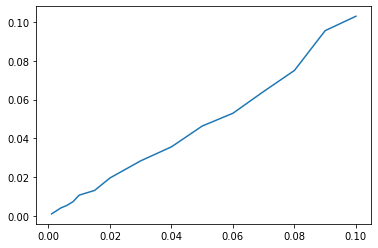

In [28]:
dimension = 2

relative_error_values = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
measured_errors = []

for error_value in relative_error_values:
    total_error = 0
    for i in range(100):
        # Specify the positions of the satellites
        satellite_positions = np.empty((0,dimension))
        for corner in itertools.product(*[[0,1]]*dimension):
            satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

        # Pick a random point in the space to measure
        point_to_measure = np.random.rand(dimension)

        satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure, error=error_value)

        measured_point = measure_point_from_satellites_n_dims_4(satellite_positions, satellite_distances)

        error = np.sqrt(sum((measured_point - point_to_measure)**2))
        total_error += error
    average_error = total_error / 100
    measured_errors.append(average_error)

plt.plot(relative_error_values, measured_errors)

Above I've plotted the results of the experiment in two dimensions. In order to describe this result, when placing satellites in each corner of the unit cube, increasing the error has a linear effect on the average uncertainty of the point measured, when the point to measure is within the unit cube. What happens in 3D?

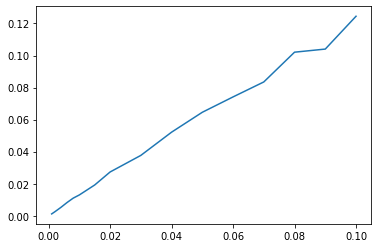

In [29]:
dimension = 3

relative_error_values = [0.001, 0.002, 0.004, 0.006, 0.008, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
measured_errors = []

for error_value in relative_error_values:
    total_error = 0
    for i in range(100):
        # Specify the positions of the satellites
        satellite_positions = np.empty((0,dimension))
        for corner in itertools.product(*[[0,1]]*dimension):
            satellite_positions = np.append(satellite_positions, np.array([corner]), axis=0)

        # Pick a random point in the space to measure
        point_to_measure = np.random.rand(dimension)

        satellite_distances = measure_satellite_distances(satellite_positions, point_to_measure, error=error_value)

        measured_point = measure_point_from_satellites_n_dims_4(satellite_positions, satellite_distances)

        error = np.sqrt(sum((measured_point - point_to_measure)**2))
        total_error += error
    average_error = total_error / 100
    measured_errors.append(average_error)

plt.plot(relative_error_values, measured_errors)

Again, in 3D we get pretty much the same result in that the effect is linear.

Now we shall move on to running an experiment in the real world, that is to simulate what this would look like when measured using GPS satellites and sensors on the Earth. In this experiment we shall assume that the Earth is a perfect sphere (it's not really, but more like an ellipsoid), and take measures of latitude, longitude, and altitude in place of Cartesian coordinates. To do this we shall first create functions to convert spherical long/lat/alt coordinates on Earth into Cartesian coordinates, and vice versa. The Cartesian coordinate system we shall use is in units of meters, and the x-axis will denote the direction of 0°N 0°E (known as [Null Island](https://en.wikipedia.org/wiki/Null_Island)), the y-axis will denote the direction of 0°N 180°E, and the z-axis will denote the direction of the North Pole. As for the radius of the earth, we shall use the value of the mean radius as obtained [here](https://en.wikipedia.org/wiki/Earth_radius), 6,371,008.7714 m.

In [34]:
earth_radius = 6371008.7714

def convert_spherical_to_cartesian(lat, long, alt, earth_radius = earth_radius):
    # latitude, longitude in degrees, and altitude in meters above the average earth radius
    radius = earth_radius + alt
    x = radius * np.cos(np.radians(lat)) * np.cos(np.radians(long))
    y = radius * np.cos(np.radians(lat)) * np.sin(np.radians(long))
    z = radius * np.sin(np.radians(lat))
    return np.array([x,y,z])

def convert_cartesian_to_spherical(x, y, z, earth_radius = earth_radius):
    radius = np.sqrt(x**2 + y**2 + z**2)
    alt = radius - earth_radius
    lat = np.degrees(np.arcsin(z/radius))
    long = np.degrees(np.arccos(x/radius/np.cos(np.radians(lat))))
    return np.array([lat, long, alt])

In [38]:
# To test this works, we shall use the coordinates of Vancouver Art Gallery as an example, and assume the altitude is 20 m above sea level.
print(convert_spherical_to_cartesian(49.28305, -123.12044, 20))
print(convert_cartesian_to_spherical(-2270823.28388494, -3480720.96658833, 4828866.40653114))

[-2270823.28388494 -3480720.96658833  4828866.40653114]
[ 49.28305 123.12044  20.     ]
